In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.datasets import make_blobs
import matplotlib
import matplotlib.patches as mpatches
import theano
import theano.tensor as T
import pydot
from IPython.display import Image
from IPython.display import SVG
import timeit

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

theano.config.floatX = 'float32'

Using gpu device 0: GeForce GTX 560M (CNMeM is enabled with initial size: 40.0% of memory, cuDNN not available)


In [2]:
n_blobs = 4

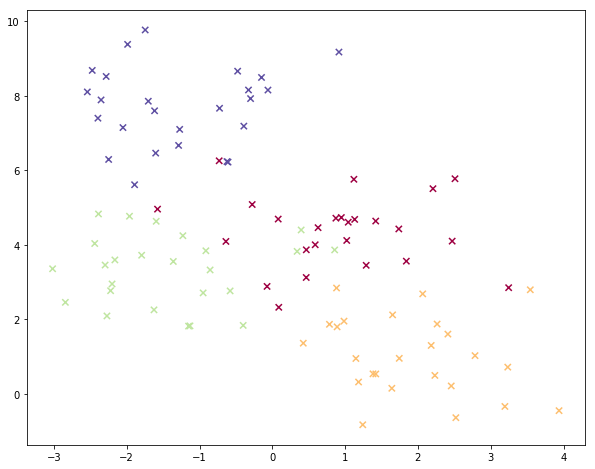

In [3]:
np.random.seed(0)
train_X, train_y = make_blobs(centers=n_blobs)
train_X = train_X.astype(np.float32)
train_y = train_y.astype(np.int32)
plt.scatter(train_X[:,0], train_X[:,1], s=40, c=train_y, cmap=plt.cm.Spectral, marker='x')

In [4]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = train_X[:, 0].min() - .5, train_X[:, 0].max() + .5
    y_min, y_max = train_X[:, 1].min() - .5, train_X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, cmap=plt.cm.Spectral)

In [5]:
# Size definitions
N = len(train_X)
input_size = 2 
output_size = n_blobs
hidden_size = 2
reg=np.float32(0.01) # reg strenght
epsilon=np.float32(0.1)  # learning rate

In [6]:
# Our data vectors
X = T.matrix('X').astype('float32') # matrix of doubles
y = T.ivector('y').astype('int32') # vector of [int] labels

# Shared variables with initial values. We need to learn these.
W1 = theano.shared(np.random.randn(input_size, hidden_size).astype('float32'), name='W1')
b1 = theano.shared(np.zeros(hidden_size).astype('float32'), name='b1')
W2 = theano.shared(np.random.randn(hidden_size, output_size).astype('float32'), name='W2')
b2 = theano.shared(np.zeros(output_size).astype('float32'), name='b2')

# Forward pass
# Note: We are just defining the expressions, nothing is evaluated here!
z1 = X.dot(W1) + b1
a1 = T.tanh(z1)
z2 = a1.dot(W2) + b2
probs = T.nnet.softmax(z2) # output probabilties

# The regularization term (optional)
loss_reg = 1./N * reg/2 * (T.sum(T.sqr(W1)) + T.sum(T.sqr(W2))) 
# the loss function we want to optimize
loss = T.nnet.categorical_crossentropy(probs, y).mean() + loss_reg

# Returns a class prediction
prediction = T.argmax(probs, axis=1)


def update():
    # Shared variables with initial values. We need to learn these.
    W1 = theano.shared(np.random.randn(input_size, hidden_size).astype('float32'), name='W1')
    b1 = theano.shared(np.zeros(hidden_size).astype('float32'), name='b1')
    W2 = theano.shared(np.random.randn(hidden_size, output_size).astype('float32'), name='W2')
    b2 = theano.shared(np.zeros(output_size).astype('float32'), name='b2')

    # Forward pass
    # Note: We are just defining the expressions, nothing is evaluated here!
    z1 = X.dot(W1) + b1
    a1 = T.tanh(z1)
    z2 = a1.dot(W2) + b2
    probs = T.nnet.softmax(z2) # output probabilties

    # The regularization term (optional)
    loss_reg = 1./N * reg/2 * (T.sum(T.sqr(W1)) + T.sum(T.sqr(W2))) 
    # the loss function we want to optimize
    loss = T.nnet.categorical_crossentropy(probs, y).mean() + loss_reg

    # Returns a class prediction
    prediction = T.argmax(probs, axis=1)
    
# Theano functions that can be called from our Python code
forward_prop = theano.function([X], probs, allow_input_downcast=True)
calculate_loss = theano.function([X, y], loss, allow_input_downcast=True)
predict = theano.function([X], prediction, allow_input_downcast=True)

# Easy: Let Theano calculate the derivatives for us!
dW2 = T.grad(loss, W2)
db2 = T.grad(loss, b2)
dW1 = T.grad(loss, W1)
db1 = T.grad(loss, b1)

gradient_step = theano.function(
    [X, y],
    updates=((W2, W2 - epsilon * dW2),
             (W1, W1 - epsilon * dW1),
             (b2, b2 - epsilon * db2),
             (b1, b1 - epsilon * db1)))

In [7]:
def show_legend():
    classes = ['Male','Pred male', 'Female', 'Pred female']
    class_colours = [plt.cm.get_cmap('Spectral')(0), plt.cm.get_cmap('binary_r')(0),
                     plt.cm.get_cmap('Spectral_r')(0), plt.cm.get_cmap('binary')(0)]
    recs = []
    for i in range(len(class_colours)):
        recs.append(mpatches.Rectangle((0,0), 1, 1, fc=class_colours[i]))
    return plt.legend(recs, classes, loc=1)

In [8]:
def make_model(epochs=20000, decay=None, batch_size=None, print_loss=None):
 
    # Re-Initialize the parameters to random values. We need to learn these.
    # (Needed in case we call this function multiple times)
    np.random.seed(0)
    W1.set_value((np.random.randn(input_size, hidden_size) / np.sqrt(input_size)).astype('float32'))
    b1.set_value((np.zeros(hidden_size)).astype('float32'))
    W2.set_value((np.random.randn(hidden_size, output_size) / np.sqrt(hidden_size)).astype('float32'))
    b2.set_value((np.zeros(output_size)).astype('float32'))
    
    for i in range(epochs):
        
        gradient_step(train_X, train_y)
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss is not None and i % print_loss == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(train_X, train_y)))

Loss after iteration 0: 1.600358
Loss after iteration 100000: 0.219655
Loss after iteration 200000: 0.219426
Loss after iteration 300000: 0.219400
Loss after iteration 400000: 0.219396
Loss after iteration 500000: 0.219395
Loss after iteration 0: 1.485271
Loss after iteration 100000: 0.167415
Loss after iteration 200000: 0.165478
Loss after iteration 300000: 0.165312
Loss after iteration 400000: 0.165284
Loss after iteration 500000: 0.165279
Loss after iteration 0: 1.633087
Loss after iteration 100000: 0.122530
Loss after iteration 200000: 0.116736
Loss after iteration 300000: 0.117030
Loss after iteration 400000: 0.116808
Loss after iteration 500000: 0.116515
Loss after iteration 0: 1.515895
Loss after iteration 100000: 0.130001
Loss after iteration 200000: 0.128814
Loss after iteration 300000: 0.128582
Loss after iteration 400000: 0.128507
Loss after iteration 500000: 0.128477
Loss after iteration 0: 1.227954
Loss after iteration 100000: 0.109930
Loss after iteration 200000: 0.107746

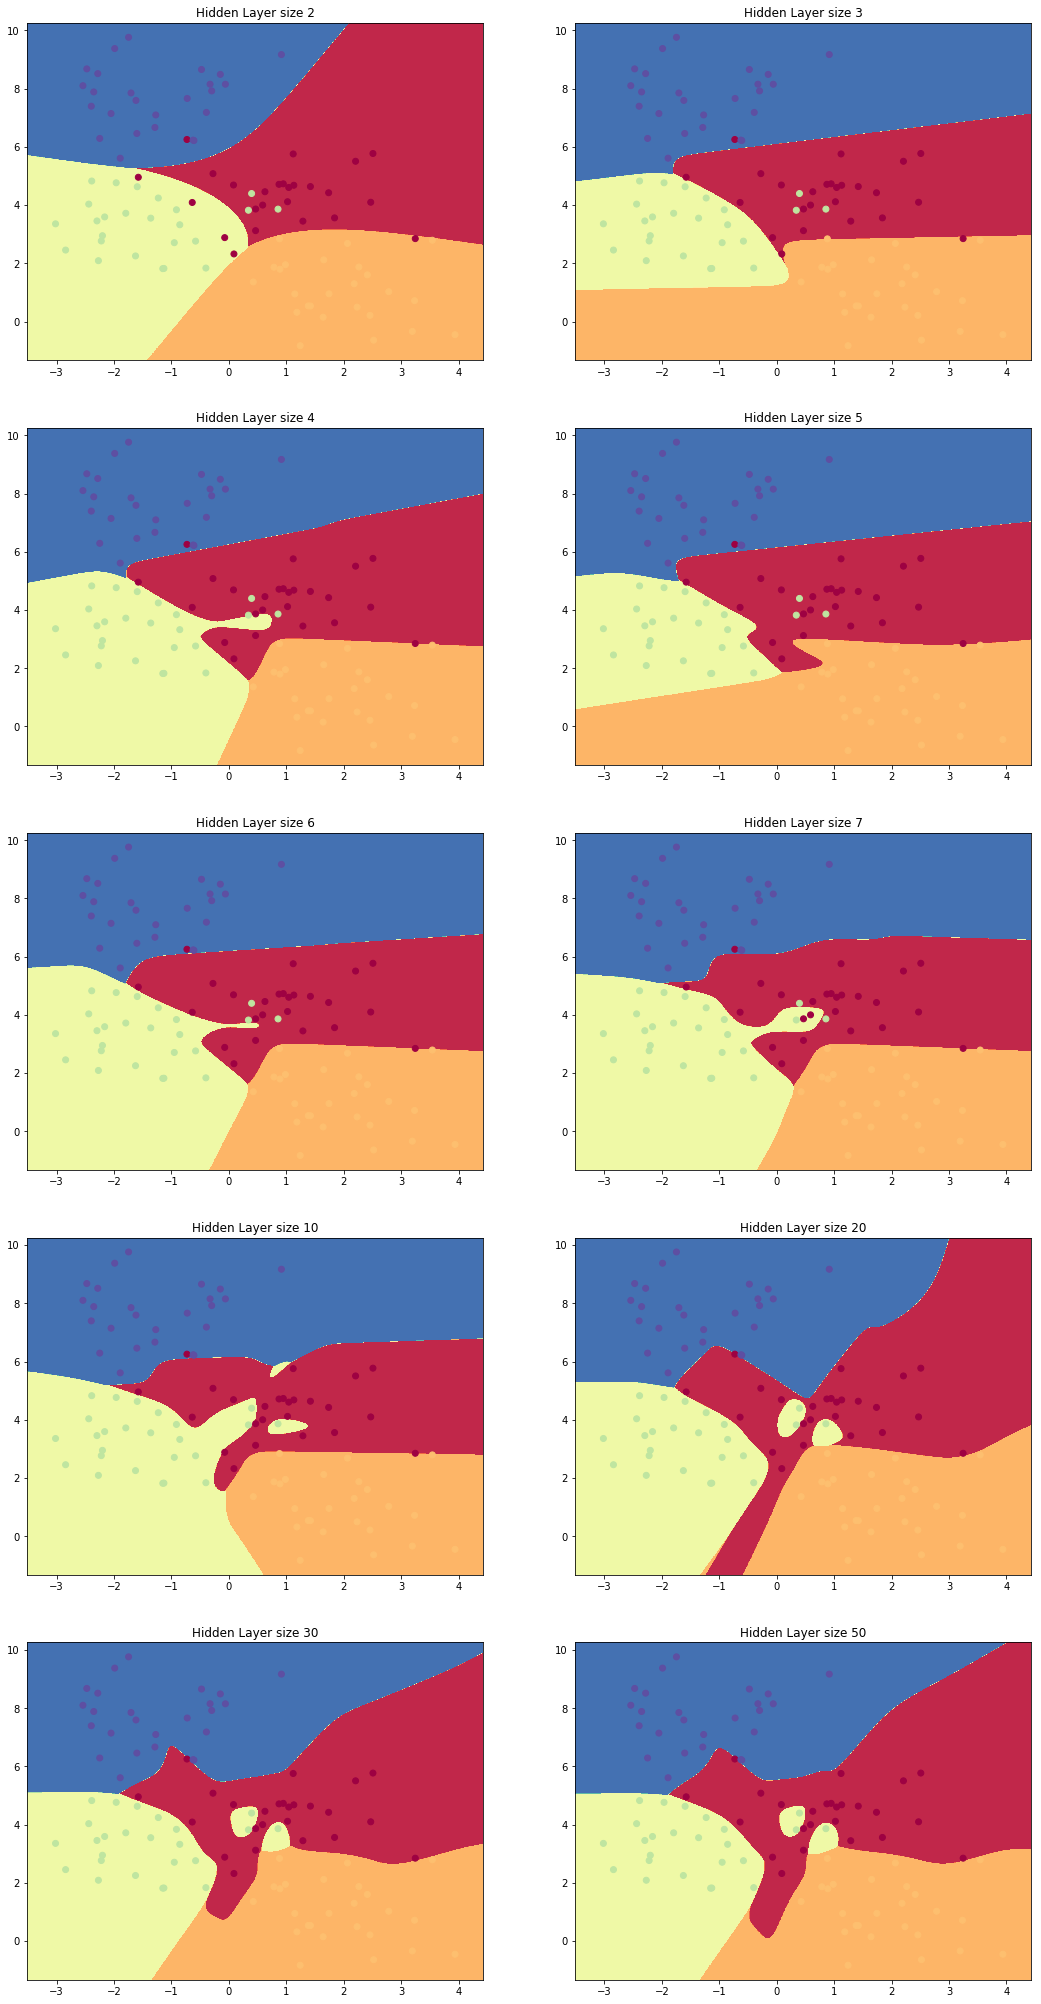

In [12]:
plt.figure(figsize=(18, 36))
hidden_sizes = [2, 3, 4, 5, 6, 7, 10, 20, 30, 50]

for i, hidden_size in enumerate(hidden_sizes):
    hidden_size = hidden_sizes[i]
    update()
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % hidden_size)
    model = make_model(epochs=500001, print_loss=100000)
    plot_decision_boundary(lambda x: predict(x))
plt.show()